<a href="https://colab.research.google.com/github/ecristallini/PolygonalFaults/blob/main/Analiza_Fallas_Poligonales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplstereonet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mplstereonet: filename=mplstereonet-0.6.3-py3-none-any.whl size=38354 sha256=05534e478088fb692f641468070c7e8fb2163e7cca22189dc46b486fd395cf46
  Stored in directory: /root/.cache/pip/wheels/25/60/d9/36fc815e7e6a4d259d770ac6281cc7beef0ba36c6eef9ac8b6
Successfully built mplstereonet


In [ ]:
import numpy as np
import mplstereonet
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString
from pyproj import Transformer
import csv
import folium
from IPython.display import display
from folium.plugins import BeautifyIcon





Monta el disco de Drive donde están los datos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Crea las clases para transformar entre coordenadas geográficas y Gauss Kruger (ida i vuelta)

In [ ]:
def geograficas_a_posgar(lat, lon):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:22182', always_xy=True)
    posgar_x, posgar_y = transformer.transform(lon, lat)
    return posgar_x, posgar_y

In [ ]:
def posgar_a_geograficas(X, Y):
    transformer = Transformer.from_crs('EPSG:22182','EPSG:4326')
    lat, lon = transformer.transform(Y, X)
    return lat, lon

Carga las fallas que ya están en coordenadas GK desde el archivo de drive.

In [ ]:
fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Experimento_1/Experimento_1.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Ines_MargasVerdes/Ines_MargasVerdes.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/TodosCubosMargasVerdes/TodosCubosMargasVerdes.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Martillo_WillyAike_MargasVerdes/Martillo_WillyAike_MargasVerdes.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/LaPorfiada_DosHermanos_MargasVerdes/LaPorfiada_DosHermanos_MargasVerdes.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Chiripa_Margas_Verdes/Chiripa_Margas_Verdes.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Campamento_MargasVerdes/Campamento_MargasVerdes.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Campo Boleadoras Merge 3D_MargasVerdes/Campo Boleadoras Merge 3D_MargasVerdes.shp')
#fallas=gpd.read_file('gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/PuestoPeter/PuestoPeter_MargasVerdes.shp')

Plotea las fallas para visualizar que esté todo bien

<Axes: >

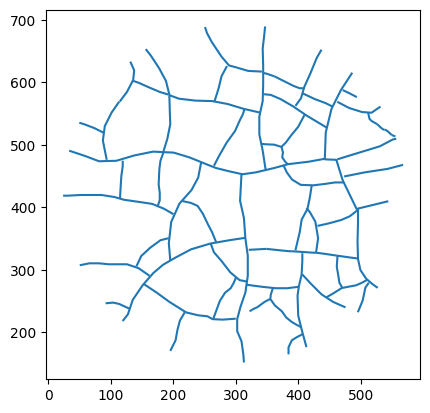

In [ ]:
fallas.plot()


Definimos la funcion azimut

In [ ]:
def azimuth(point1, point2):
    '''azimuth between 2 shapely points (interval 0 - 360)'''
    angle = np.arctan2(point2.x - point1.x, point2.y - point1.y)
    return np.degrees(angle) if angle >= 0 else np.degrees(angle) + 360

Ahora vamos a calcular los angulos y largos de cada segmento de cada falla (las fallas pueden tener uno o más segmentos)

In [ ]:
#Primero voy a separar los segmentos de adentro de cada falla y construir una lista de segmentos
segmentos=[]
azimutes=[]
dips=[]
resultado=[]

for f in fallas.geometry:
  coordenadas = list(f.coords)
  puntoAnterior=coordenadas[0]
  for i in range(1,len(coordenadas)):
    segmentos.append(LineString([puntoAnterior, coordenadas[i]]))
    puntoAnterior=coordenadas[i]

for s in segmentos:
  l=int(s.length)
  p1=Point(s.coords[0])
  p2=Point(s.coords[1])
  a=azimuth(p1,p2)
  resultado.append([a,l])
  azimutes.append(a)
  dips.append(90)

  #for n in range(l):
  #  azimutes.append(a)
  #  dips.append(90)




Comienzo con el gráfico de rosetas

Calculate the number of directions (azimutes) every 10° using numpy.histogram.

In [ ]:
bin_edges = np.arange(-5, 366, 10)
#bin_edges = np.arange(-10, 371, 20)
#bin_edges = np.arange(0, 381, 20)
number_of_strikes, bin_edges = np.histogram(azimutes, bin_edges)

Sum the last value with the first value.

In [ ]:
number_of_strikes[0] += number_of_strikes[-1]

Sum the first half 0-180° with the second half 180-360° to achieve the "mirrored behavior" of Rose Diagrams.

In [ ]:
half = np.sum(np.split(number_of_strikes[:-1], 2), 0)
two_halves = np.concatenate([half, half])

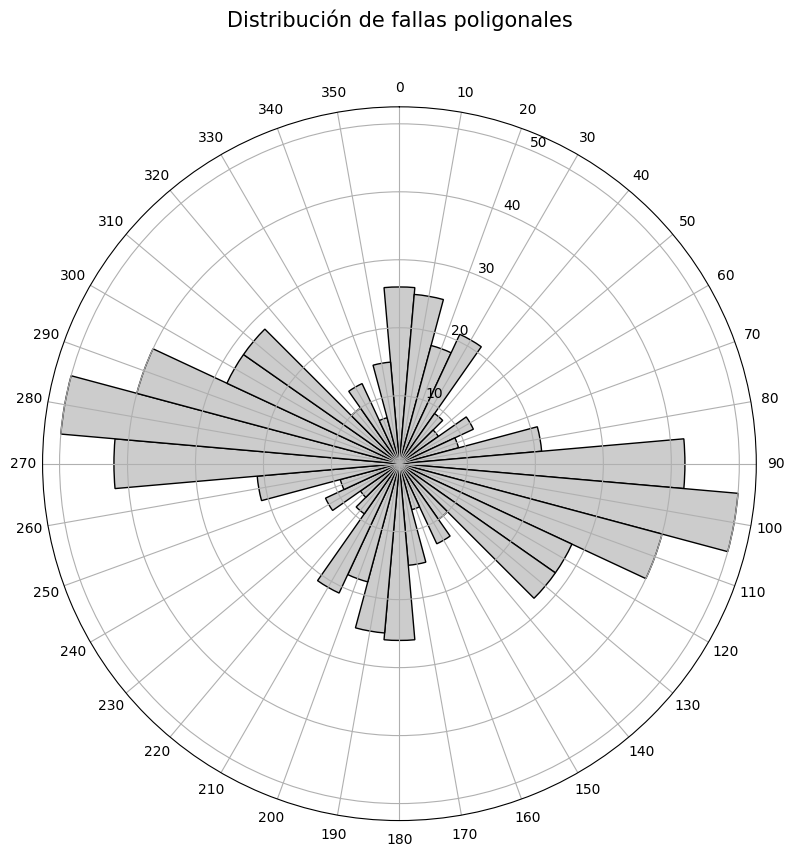

In [ ]:


fig = plt.figure(figsize=(16,8))

#ax = fig.add_subplot(121, projection='stereonet')

#ax.pole(azimutes, dips, c='k', label='Pole of the Planes')
#ax.density_contourf(azimutes, dips, measurement='poles', cmap='Reds')
#ax.set_title('Density coutour of the Poles', y=1.10, fontsize=15)
#ax.grid()

ax = fig.add_subplot(122, projection='polar')

ax.bar(np.deg2rad(np.arange(0, 360, 10)), two_halves,
       width=np.deg2rad(10), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
#ax.set_rgrids(np.arange(1, two_halves.max() + 1, 2), angle=0, weight= 'black')
ax.set_title('Distribución de fallas poligonales', y=1.10, fontsize=15)

fig.tight_layout()


Salva archivo en formato estereográfica web

In [ ]:
nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Experimento_1/Experimento_1_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Ines_MargasVerdes/Ines_MargasVerdes_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/TodosCubosMargasVerdes/TodosCubosMargasVerdes_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Martillo_WillyAike_MargasVerdes/Martillo_WillyAike_MargasVerdes_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/LaPorfiada_DosHermanos_MargasVerdes/LaPorfiada_DosHermanos_MargasVerdes_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Chiripa_Margas_Verdes/Chiripa_Margas_Verdes_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Campamento_MargasVerdes/Campamento_MargasVerdes_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Campo Boleadoras Merge 3D_MargasVerdes/Campo Boleadoras Merge 3D_MargasVerdes.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/PuestoPeter/PuestoPeter_MargasVerdes.csv'  # Ruta del archivo en tu Google Drive


with open(nombre_archivo, 'w') as archivo:
  texto='Nombre;Azimut;Inclinacion;TipoDato;TipoAzimut;R;G;B;Grosor;EstriaAzi;EstriaIncli;EstriaMov;EstriaRke;Peso'
  archivo.write(texto+ '\n')

  for p in resultado:
    indice=resultado.index(p)
    texto="{:.0f}".format(indice)+';'+"{:.0f}".format(p[0])+';'+'90'+';'+'P'+';'+'0'+';0;128;0;2;0;0;;0;'+"{:.0f}".format(p[1])

    #texto=pozos[indice][0]+','+pozos[indice][1]+','+"{:.2f}".format(inf[0])+','+"{:.2f}".format(inf[1])+','+"{:.0f}".format(inf[2])

    archivo.write(texto+ '\n')


archivo.close()


Vamos a calcular el ángulo entre fracturas cuando sus extremos están a menos de un valor humbral

In [ ]:
def diferenciaAzimutes(a1,a2):
  if a2>a1:
    a2=a2-a1
    if a2<=180:
      return a2
    else:
      return 360-a2
  else:
    a1=a1-a2
    if a1<=180:
      return a1
    else:
      return 360-a1


In [ ]:

angulosRamas=[]
humbral=10 #distancia humbral para calcular ángulos

nudosOriginal=[]

for i in range(0,len(segmentos)):
  s0=segmentos[i]
  p1=Point(s0.coords[0])
  p2=Point(s0.coords[1])

  nudosOriginal.append(p1)
  nudosOriginal.append(p2)

  for j in range(0,len(segmentos)):
    if j!=i:
      s1=segmentos[j]
      pp1=Point(s1.coords[0])
      pp2=Point(s1.coords[1])
      a=azimuth(p1,p2)

      if ((p1.x - pp1.x)**2 + (p1.y - pp1.y)**2)**0.5<humbral:
        b=azimuth(pp1,pp2)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))

      elif((p1.x - pp2.x)**2 + (p1.y - pp2.y)**2)**0.5<humbral:
        b=azimuth(pp2,pp1)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))

      a=azimuth(p2,p1)

      if ((p2.x - pp1.x)**2 + (p2.y - pp1.y)**2)**0.5<humbral:
        b=azimuth(pp1,pp2)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))

      elif((p2.x - pp2.x)**2 + (p2.y - pp2.y)**2)**0.5<humbral:
        b=azimuth(pp2,pp1)
        diferencia=diferenciaAzimutes(a,b)
        angulosRamas.append(int(diferencia))

print (len(angulosRamas))

3006


Vamos a calcular los nudos de fracturas (la intersección y salvarlas)

In [ ]:

nudos=nudosOriginal

print ('entrada: ',len(nudos))

borro=True
j_select=0

while borro==True:

  for j in range(j_select,len(nudos)-1):
    n_evaluado=nudos[j]
    borro=False


    for i in range(j+1,len(nudos)):

      n_testeo=nudos[i]
      distancia = math.sqrt((n_testeo.x-n_evaluado.x)**2+(n_testeo.y-n_evaluado.y)**2)
      if distancia<400:
        n_evaluado=Point((n_testeo.x+n_evaluado.x)/2,(n_testeo.y+n_evaluado.y)/2)
        nudos.remove(n_testeo)
        borro=True
        break

    if borro==True:
      j_select=j
      break


print ('salida: ',len(nudos))

entrada:  2
salida:  2


Salva archivo con los nudos

In [ ]:
nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Experimento_1/Nudos_Experimento_1.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Ines_MargasVerdes/Nudos_Ines_MargasVerdes.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/TodosCubosMargasVerdes/Nudos_TodosCubosMargasVerdes.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Martillo_WillyAike_MargasVerdes/Nudos_Martillo_WillyAike_MargasVerdes.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/LaPorfiada_DosHermanos_MargasVerdes/Nudos_LaPorfiada_DosHermanos_MargasVerdes.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Chiripa_Margas_Verdes/Nudos_Chiripa_Margas_Verdes.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Campamento_MargasVerdes/Nudos_Campamento_MargasVerdes_Estereo.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/Campo Boleadoras Merge 3D_MargasVerdes/Nudos_Campo Boleadoras Merge 3D_MargasVerdes.csv'  # Ruta del archivo en tu Google Drive
#nombre_archivo = 'gdrive/My Drive/Colab Notebooks/CuencaAustral/Datos/PuestoPeter/Nudos_PuestoPeter_MargasVerdes.csv'  # Ruta del archivo en tu Google Drive


with open(nombre_archivo, 'w') as archivo:
  # texto='Nombre;Azimut;Inclinacion;TipoDato;TipoAzimut;R;G;B;Grosor;EstriaAzi;EstriaIncli;EstriaMov;EstriaRke;Peso'
  # archivo.write(texto+ '\n')

  for n in nudos:
    indice=resultado.index(p)
    texto="{:.2f}".format(n.x)+';'+"{:.2f}".format(n.y)


    archivo.write(texto+ '\n')


archivo.close()


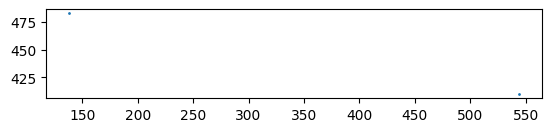

In [ ]:
xplot=[]
yplot=[]

for n in nudos:
  xplot.append(n.x)
  yplot.append(n.y)


fig, ax = plt.subplots()
ax.scatter(xplot, yplot,s=1)
ax.set_aspect("equal", adjustable="box")


# plt.scatter(xplot,yplot)
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.title("Scatter Plot")
# plt.axes.set_aspect("equal", adjustable="box")
plt.show()

Text(0.5, 1.0, 'Angulos entre fallas')

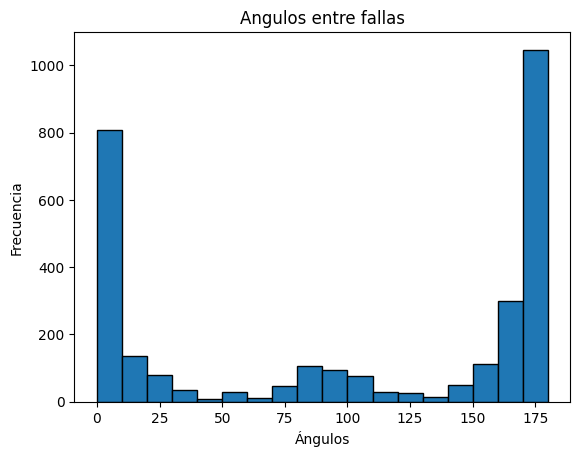

In [ ]:
fig, bx = plt.subplots()
bin_width = 10
bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(angulosRamas, bins=bins, edgecolor = "black")

plt.xlabel('Ángulos')
plt.ylabel('Frecuencia')
plt.title('Angulos entre fallas')

Text(0.5, 1.0, 'Longitudes de fallas')

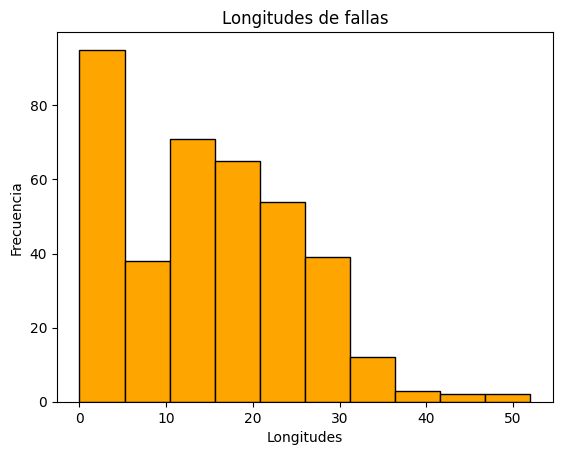

In [ ]:

largos=[]
sumaMediaLong=0
sumaMediaAng=0
for r in resultado:
  largos.append(r[1])
  sumaMediaLong=sumaMediaLong+r[1]
  sumaMediaAng=sumaMediaAng+r[0]

mediaLong=sumaMediaLong/len(largos)
mediaAng=sumaMediaAng/len(largos)

fig, bx = plt.subplots()
# bin_width = 10
# bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(largos, edgecolor = "black", color = "orange")

plt.xlabel('Longitudes')
plt.ylabel('Frecuencia')
plt.title('Longitudes de fallas')

Pongo resultados finales

In [ ]:
# intersection between line(p1, p2) and line(p3, p4)
def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)

In [ ]:
centroide=fallas.dissolve().centroid #calcual el centroide de todos los puntos de todas las fallas (para eso lo disuelve)
# xMax=2360000
# xMin=2320000
# yMax=4418000
# yMin=4379000

# xMax=2394900
# xMin=2359500
# yMax=4395700
# yMin=4357900

xMax=fallas.total_bounds[2]
xMin=fallas.total_bounds[0]
yMax=fallas.total_bounds[3]
yMin=fallas.total_bounds[1]

espaciamientoEW=[]
espaciamientoNS=[]

for i in range(int(yMin),int(yMax),1000):
  p1=(xMin,i)
  p2=(xMax,i)
  interMinX=999999999
  interMaxX=-999999999
  numerInter=0
  for f in fallas.geometry:
    coordenadas = list(f.coords)
    p3=coordenadas[0]
    p4=coordenadas[1]
    inter=intersect(p1,p2,p3,p4)
    if inter is not None:
      numerInter=numerInter+1
      if inter[0]<interMinX:
        interMinX=inter[0]
      if inter[0]>interMaxX:
        interMaxX=inter[0]

  if numerInter>1:
    espaciamiento=(interMaxX-interMinX)/(numerInter-1)
    espaciamientoEW.append(espaciamiento)



for i in range(int(xMin),int(xMax),1000):
  p1=(i,yMin)
  p2=(i,yMax)
  interMinY=999999999
  interMaxY=-999999999
  numerInter=0
  for f in fallas.geometry:
    coordenadas = list(f.coords)
    p3=coordenadas[0]
    p4=coordenadas[1]
    inter=intersect(p1,p2,p3,p4)
    if inter is not None:
      numerInter=numerInter+1
      if inter[1]<interMinY:
        interMinY=inter[1]
      if inter[1]>interMaxY:
        interMaxY=inter[1]


  if numerInter>1:
    espaciamiento=(interMaxY-interMinY)/(numerInter-1)
    espaciamientoNS.append(espaciamiento)



Text(0.5, 1.0, 'Espaciamiento')

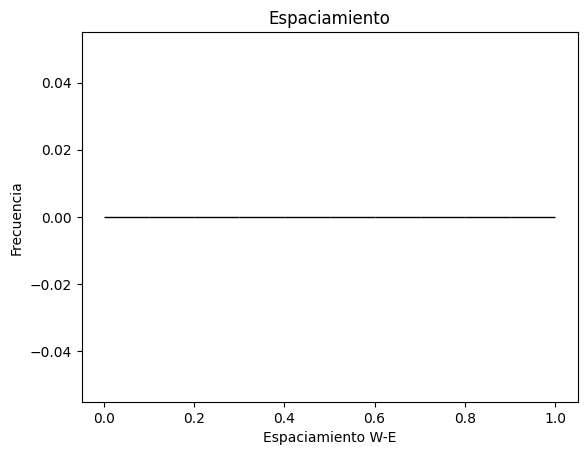

In [ ]:
fig, bx = plt.subplots()
# bin_width = 10
# bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(espaciamientoEW, edgecolor = "black", color = "orange")

plt.xlabel('Espaciamiento W-E')
plt.ylabel('Frecuencia')
plt.title('Espaciamiento')

Text(0.5, 1.0, 'Espaciamiento')

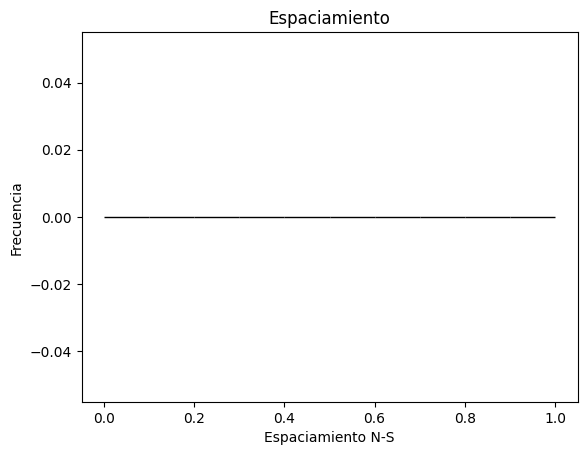

In [ ]:
fig, bx = plt.subplots()
# bin_width = 10
# bins = range(min(angulosRamas), max(angulosRamas) + bin_width, bin_width)

bx.hist(espaciamientoNS, edgecolor = "black", color = "orange")

plt.xlabel('Espaciamiento N-S')
plt.ylabel('Frecuencia')
plt.title('Espaciamiento')

In [ ]:

apotema=np.sqrt(mediaLong**2-(0.5*mediaLong)**2)

perimetro=6*mediaLong
area=perimetro*apotema/2

print ('Media de largos= ',"{:.0f}".format(mediaLong),'m')

print ('Area= ',"{:.2f}".format(area/1000000),' km2')
print ('Media de ángulos= ',"{:.0f}".format(mediaAng),'°')



Media de largos=  15 m
Area=  0.00  km2
Media de ángulos=  159 °
